In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd

# import matplotlib.pyplot as plt
# import numpy as np
# import scanpy as sc
# import seaborn as sns

In [4]:
import datetime

today = datetime.datetime.now().strftime("%Y%m%d")

In [5]:
import spatialdata as sd

In [6]:
data_dir = os.path.abspath("/home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 53 Mar 12 17:01 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark


In [7]:
cohort_name = "foxf2"
slide_name = "s2"
region_name = "r1"
sample_name = f"{cohort_name}_{slide_name}_{region_name}"
ficture_sdata_file = os.path.join(
    data_dir, "samples", sample_name, "results", "Ficture", "sdata.zarr"
)
master_sdata_file = os.path.join(data_dir, "samples", sample_name, "sdata_z3.zarr")

In [8]:
factor_abbr = "nF21"
factor_name = "nF21.d_6-bulkRNAseq-exclMBP"

In [9]:
output_dir = os.path.join(data_dir, "samples", sample_name, "plots")
os.makedirs(output_dir, exist_ok=True)

# Functions

In [10]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

colors_dapi = [(0, 0, 0), (0, 0, 1)]  # Black to blue
blue_cmap = LinearSegmentedColormap.from_list("custom_blue", colors_dapi)

colors_dapi = [(1, 1, 1), (0, 0, 1)]  # White to blue
white_blue_cmap = LinearSegmentedColormap.from_list("white_blue", colors_dapi)

In [11]:
def visualize_spatial_data(
    sdata_sub,
    celltype_to_factor,
    colors,
    dotsize,
    data_dir,
    sample_name,
    date_var,
    vname,
    factor_name,
    fict,
    cmap=blue_cmap,
    show_in_notebook=True,
    bounds=None,
):
    """
    Plot Ficture on DAPI background.
    """
    output_dir = os.path.join(data_dir, "samples", sample_name, "plots")
    os.makedirs(output_dir, exist_ok=True)

    style_settings = {
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "xtick.bottom": False,
        "xtick.labelbottom": False,
        "ytick.left": False,
        "ytick.labelleft": False,
    }

    with plt.style.context("default"), mpl.rc_context(style_settings):
        # Initialize plot with DAPI image
        plot = sdata_sub.pl.render_images(
            element="foxf2_s2_r1_z3", channel="DAPI", cmap=cmap
        )

        # Add boundaries if provided
        if bounds:
            for bound in bounds:
                plot = plot.pl.render_shapes(
                    element=bound,
                    outline_width=0.7,
                    outline_alpha=0.7,
                    outline_color="white",
                    color="white",
                    fill_alpha=0.1,
                )

        factor_key = f"{factor_name}_factors"

        # Add markers for each cell type based on factor values
        for cell_type, factor_i in celltype_to_factor.items():
            if factor_i not in sdata_sub[fict][factor_key]:
                continue
            factor_cells = (sdata_sub[fict][factor_key] == factor_i).compute().sum()
            print(f"Plotting {factor_cells} cells for {cell_type} ({factor_i})")
            plot = plot.pl.render_points(
                fict,
                color=factor_key,
                groups=factor_i,
                palette={factor_i: colors[cell_type]},
                size=dotsize,
            )

        plot.pl.show(figsize=(18, 10))

        # Save with appropriate filename
        if bounds and len(bounds) == 1:
            boundary_part = "_" + bounds[0].split("boundaries_")[1]
        else:
            boundary_part = ""
        filename = f"{today}_{vname}{boundary_part}.png"
        plt.savefig(
            os.path.join(output_dir, filename),
            dpi=500,
            bbox_inches="tight",
            pad_inches=0.2,
            transparent=False,
        )

        if not show_in_notebook:
            plt.close()

In [12]:
# plot colors from UMAP / cell type annotations

# load nF21 annotation
ficture_annotations = pd.read_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "Ficture",
        "analysis",
        "factor_annotation",
        "20250212_factor_annotations.csv",
    )
)
ficture_annotations = ficture_annotations[
    ficture_annotations["factor_method"] == factor_abbr
].sort_values(by="factor")
# ficture_annotations["factor"] = ficture_annotations["factor"].astype(str)

# slightly adjusted to match factor names
colors_all = {
    "ECs": "#FF6464",  #
    "SMCs-Pericytes": "#F6EC2A",  #
    "SMCs": "#29FBA7",  #
    "Fibroblasts": "#85B0F9",  #
    "Ependymal": "#FDC000",  #
    "Choroid Plexus": "#BF9800",
    "Astrocytes": "#FE9A30",  #
    "Oligodendrocytes": "#4564FF",  #
    "OPCs": "#2024FF",  #
    "Microglia": "#00C088",  #
    "Macrophages": "#00F3D8",  #
    "Immune": "#98DF8A",  #
    "Neurons-Gaba": "#B449F8",  #
    "Neurons-Glut": "#CEB3FF",  #
    "Neurons-Dopa": "#FCA0FF",  #
    "Neurons-Immature": "#FF50E5",  #
    "Neurons-Other": "#FCA0FF",  #
    "Unassigned": "#BDBDBD",  #
    "Astrocyte-Immune": "#FE9A30",  #
}

ficture_annotations["color"] = ficture_annotations["cell_type"].map(colors_all)

In [40]:
ficture_annotations.head(20)

factor_method  factor         cell_type confidence    input_cell_type  \
154          nF21       0        Astrocytes       high         Astrocytes   
155          nF21       1            Immune       high               BAMs   
156          nF21       2               ECs       high                ECs   
157          nF21       3         Ependymal       high          Ependymal   
158          nF21       4       Macrophages     medium       Immune-Other   
159          nF21       5         Microglia     medium          Microglia   
160          nF21       6      Neurons-Gaba       high  Neurons-Dopa-Gaba   
161          nF21       7      Neurons-Gaba       high       Neurons-Gaba   
162          nF21       8      Neurons-Glut       high       Neurons-Glut   
163          nF21       9     Neurons-Other     medium  Neurons-Glyc-Gaba   
164          nF21      10  Neurons-Immature       high   Neurons-Immature   
165          nF21      11     Neurons-Other     medium      Neurons-Other   
166          nF21      12  Astrocyte-Immune     medium               OECs   
167          nF21      13              OPCs       high               OPCs   
168          nF21      14  Oligodendrocytes       high   Oligodendrocytes   
169          nF21      15    SMCs-Pericytes       high          Pericytes   
170          nF21      16              SMCs       high               SMCs   
171          nF21      17       Fibroblasts       high              VLMCs   
172          nF21      18       Fibroblasts       high               ABCs   
173          nF21      19        Astrocytes       high           Bergmann   

       color  
154  #FE9A30  
155  #98DF8A  
156  #FF6464  
157  #FDC000  
158  #00F3D8  
159  #00C088  
160  #B449F8  
161  #B449F8  
162  #CEB3FF  
163  #FCA0FF  
164  #FF50E5  
165  #FCA0FF  
166  #FE9A30  
167  #2024FF  
168  #4564FF  
169  #F6EC2A  
170  #29FBA7  
171  #85B0F9  
172  #85B0F9  
173  #FE9A30

In [31]:
# Create a mapping from factor values to colors
factor_to_color = dict(zip(ficture_annotations["factor"], ficture_annotations["color"]))

In [32]:
factor_to_color

{0: '#FE9A30',
 1: '#98DF8A',
 2: '#FF6464',
 3: '#FDC000',
 4: '#00F3D8',
 5: '#00C088',
 6: '#B449F8',
 7: '#B449F8',
 8: '#CEB3FF',
 9: '#FCA0FF',
 10: '#FF50E5',
 11: '#FCA0FF',
 12: '#FE9A30',
 13: '#2024FF',
 14: '#4564FF',
 15: '#F6EC2A',
 16: '#29FBA7',
 17: '#85B0F9',
 18: '#85B0F9',
 19: '#FE9A30',
 20: '#FCA0FF',
 21: '#BDBDBD'}

# Load sdata

In [15]:
if "sdata" not in locals():
    sdata = sd.read_zarr(master_sdata_file)

In [16]:
# sdata

In [17]:
# reduce size of sdata for speed
del sdata["foxf2_s2_r1_z3"]
for k in list(sdata.tables.keys()):
    del sdata[k]
for k in list(sdata.shapes.keys()):
    del sdata[k]

In [18]:
if "ficture_sdata" not in locals():
    ficture_sdata = sd.read_zarr(ficture_sdata_file)

In [19]:
# ficture_sdata

In [20]:
fict_element = "ficture_transcripts"
fict_temp = ficture_sdata["foxf2_s2_r1_all_transcript_factors"].copy()
fict_temp[factor_abbr + "_factors"] = (
    fict_temp[factor_abbr + "_factors"].astype("str").astype("category")
)

In [21]:
# add ficture results to master sdata temporarily
sdata[fict_element] = fict_temp

In [22]:
del ficture_sdata

In [23]:
sdata["foxf2_s2_r1_transcripts"].head(2)

x          y  gene              cell_id  barcode_id  \
0  7136.4756  2356.3298  Igf2  1865558700069100825           0   
1  7138.1094  2360.3838   Cfp  1865558700069100825           8   

        transcript_id  fov  Unnamed: 0  global_z  
0  ENSMUST00000000033  461         107       0.0  
1  ENSMUST00000001156  461          22       0.0

In [24]:
sdata["foxf2_s2_r1_transcripts"].dtypes

x                        float64
y                        float64
gene                    category
cell_id                    int64
barcode_id                 int64
transcript_id    string[pyarrow]
fov                        int64
Unnamed: 0                 int64
global_z                 float64
dtype: object

In [25]:
sdata["foxf2_s2_r1_transcripts"].head(10).gene.unique()

['Igf2', 'Cfp', 'Slc3a2', 'Slc47a1', 'Pttg1', 'Hif1a', 'Vcl', 'Epas1', 'Slc7a11']
Categories (550, object): ['A830036E02Rik', 'AI593442', 'Abca1', 'Abcb1a', ..., 'Xirp1', 'Zcchc14', 'Zeb1', 'Zic3']

In [26]:
sdata[fict_element].head(2)

x          y  global_z  gene       transcript_id  nF50_factors  \
0  7136.4756  2356.3298       0.0  Igf2  ENSMUST00000000033            50   
1  7138.1094  2360.3838       0.0   Cfp  ENSMUST00000001156            50   

   nF28_factors  nF10_factors  nF30_factors  nF5_factors  nF25_factors  \
0            28            10            30            5            25   
1            28            10            30            5            25   

  nF21_factors  nF20_factors  
0           21            20  
1           21            20

In [27]:
sdata[fict_element][factor_abbr + "_factors"].compute().unique()

['21', '0', '13', '2', '15', ..., '1', '18', '11', '4', '12']
Length: 22
Categories (22, string): [0, 1, 10, 11, ..., 7, 8, 9, 12]

In [28]:
sdata[fict_element].dtypes

x                        float64
y                        float64
global_z                 float64
gene                    category
transcript_id    string[pyarrow]
nF50_factors               int64
nF28_factors               int64
nF10_factors               int64
nF30_factors               int64
nF5_factors                int64
nF25_factors               int64
nF21_factors            category
nF20_factors               int64
dtype: object

# Plot

In [73]:
# subset transcripts for fast plotting
fict_element_small = "fict_sub"
sdata[fict_element_small] = sdata[fict_element].sample(frac=0.5)

In [74]:
sdata[fict_element_small].head()

x          y  global_z     gene       transcript_id  \
199484  6320.515  2190.9636       1.0      Clu  ENSMUST00000022616   
125271  6252.365  2633.6306       5.0     Meg3  ENSMUST00000146701   
347850  6349.437  2035.7222       4.0     Meg3  ENSMUST00000146701   
262562  6329.465  2362.2944       5.0  Slc17a7  ENSMUST00000085374   
632269  6353.699  1457.2802       4.0    Itgb1  ENSMUST00000090006   

        nF50_factors  nF28_factors  nF10_factors  nF30_factors  nF5_factors  \
199484            38             7             5            10            0   
125271             0            10             2             1            0   
347850             0             7             2             1            0   
262562             2            14             0             3            0   
632269             2             7             0             3            0   

        nF25_factors nF21_factors  nF20_factors  
199484            18            8            13  
125271             7           11             9  
347850             1            8             1  
262562             3            0             4  
632269             3            8             4

In [75]:
# plt.scatter much faster than sdata.pl.render_points for all points
x_values = sdata[fict_element_small]["x"].compute()
y_values = sdata[fict_element_small]["y"].compute()
color_values = sdata[fict_element_small]["nF21_factors"].compute()
color_values_mapped = color_values.map(lambda x: factor_to_color[int(x)])

In [ ]:
vname = "full_slide"
plt.figure(figsize=(12, 12))
fig = plt.scatter(
    y_values, x_values, c=color_values_mapped, s=0.02, alpha=1, edgecolors="none"
)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.gca().invert_yaxis()
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=400,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()

In [79]:
#

In [76]:
# vname = "full_slide"
# plot = sdata.pl.render_points(
#    fict_element_small,
#    color=f"{factor_abbr}_factors",
#    palette=list(factor_to_color.values()),
#    groups=[str(k) for k in factor_to_color.keys()],
#    size=0.01,
#    method="matplotlib"
# )
# fig = plot.pl.show(figsize=(18, 18))
# plt.axis('off')
# plt.savefig(os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
#            dpi=500,
#            bbox_inches='tight',
#            pad_inches=0.2,
#            transparent=True)
# plt.show()

In [26]:
# pial1
# pixel scale
vname = "large_artery1"
bb_xmin = 52800
bb_ymin = 35800
bb_w = 4300
bb_h = 1200
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [27]:
sdata_sub = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

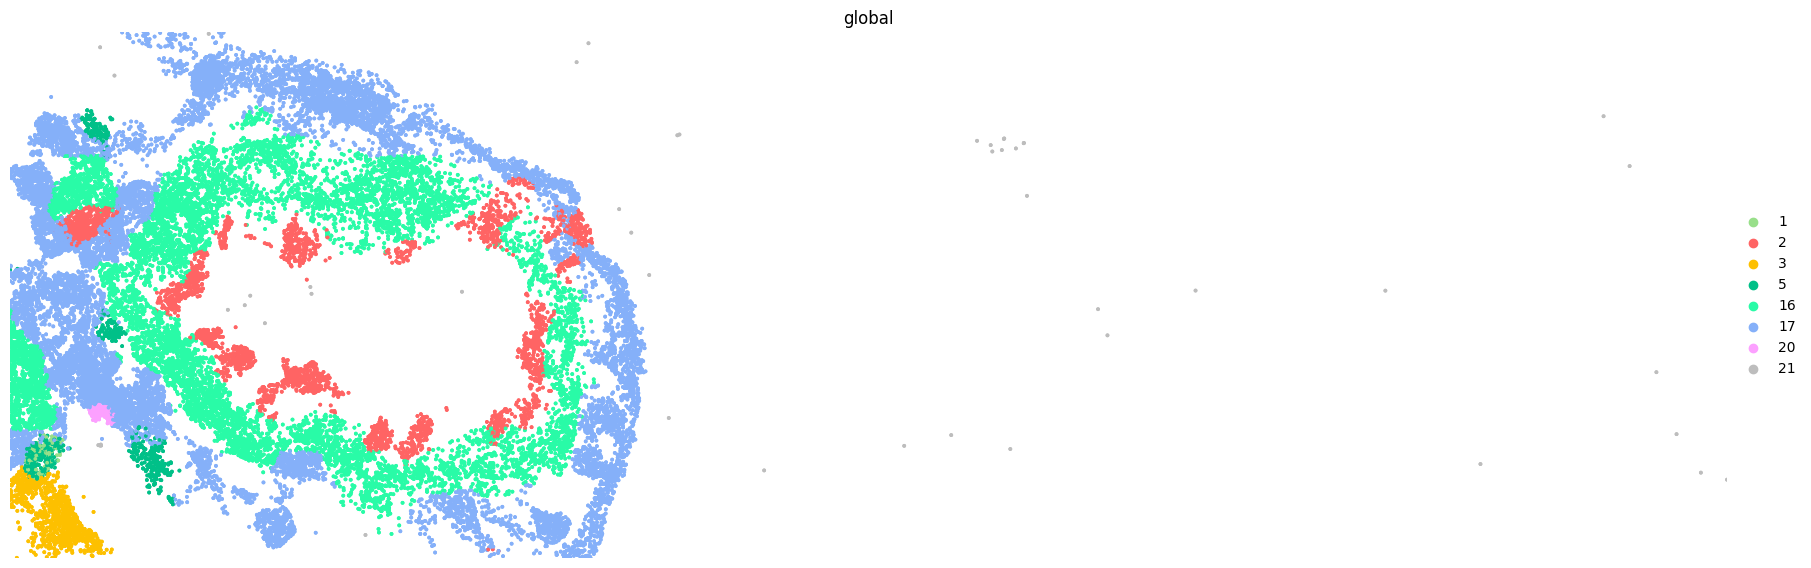

In [70]:
plot = sdata_sub.pl.render_points(
    fict_element,
    color=f"{factor_abbr}_factors",
    palette=list(factor_to_color.values()),
    groups=[str(k) for k in factor_to_color.keys()],
    size=3,
    method="matplotlib",
)
fig = plot.pl.show(figsize=(18, 18))
plt.axis("off")
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()

In [81]:
# cap1
# pixel scale
vname = "capillaries1"
bb_xmin = 24200
bb_ymin = 31200
bb_w = 2500
bb_h = 1500
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [82]:
sdata_sub = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

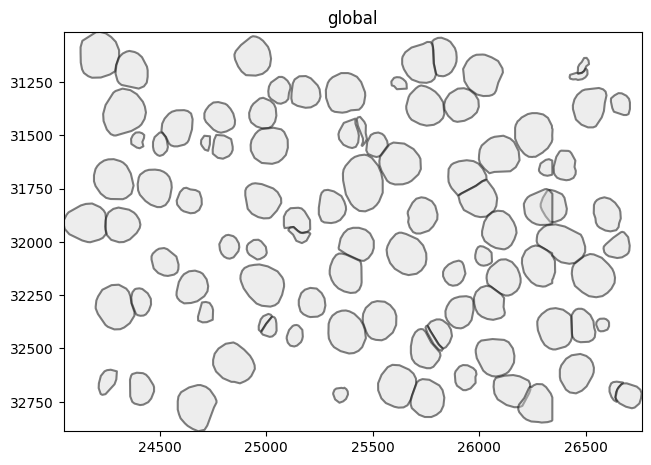

In [69]:
sdata_sub.pl.render_shapes(
    element=bounds[1],
    outline_alpha=0.5,
    fill_alpha=0.4,
).pl.show()

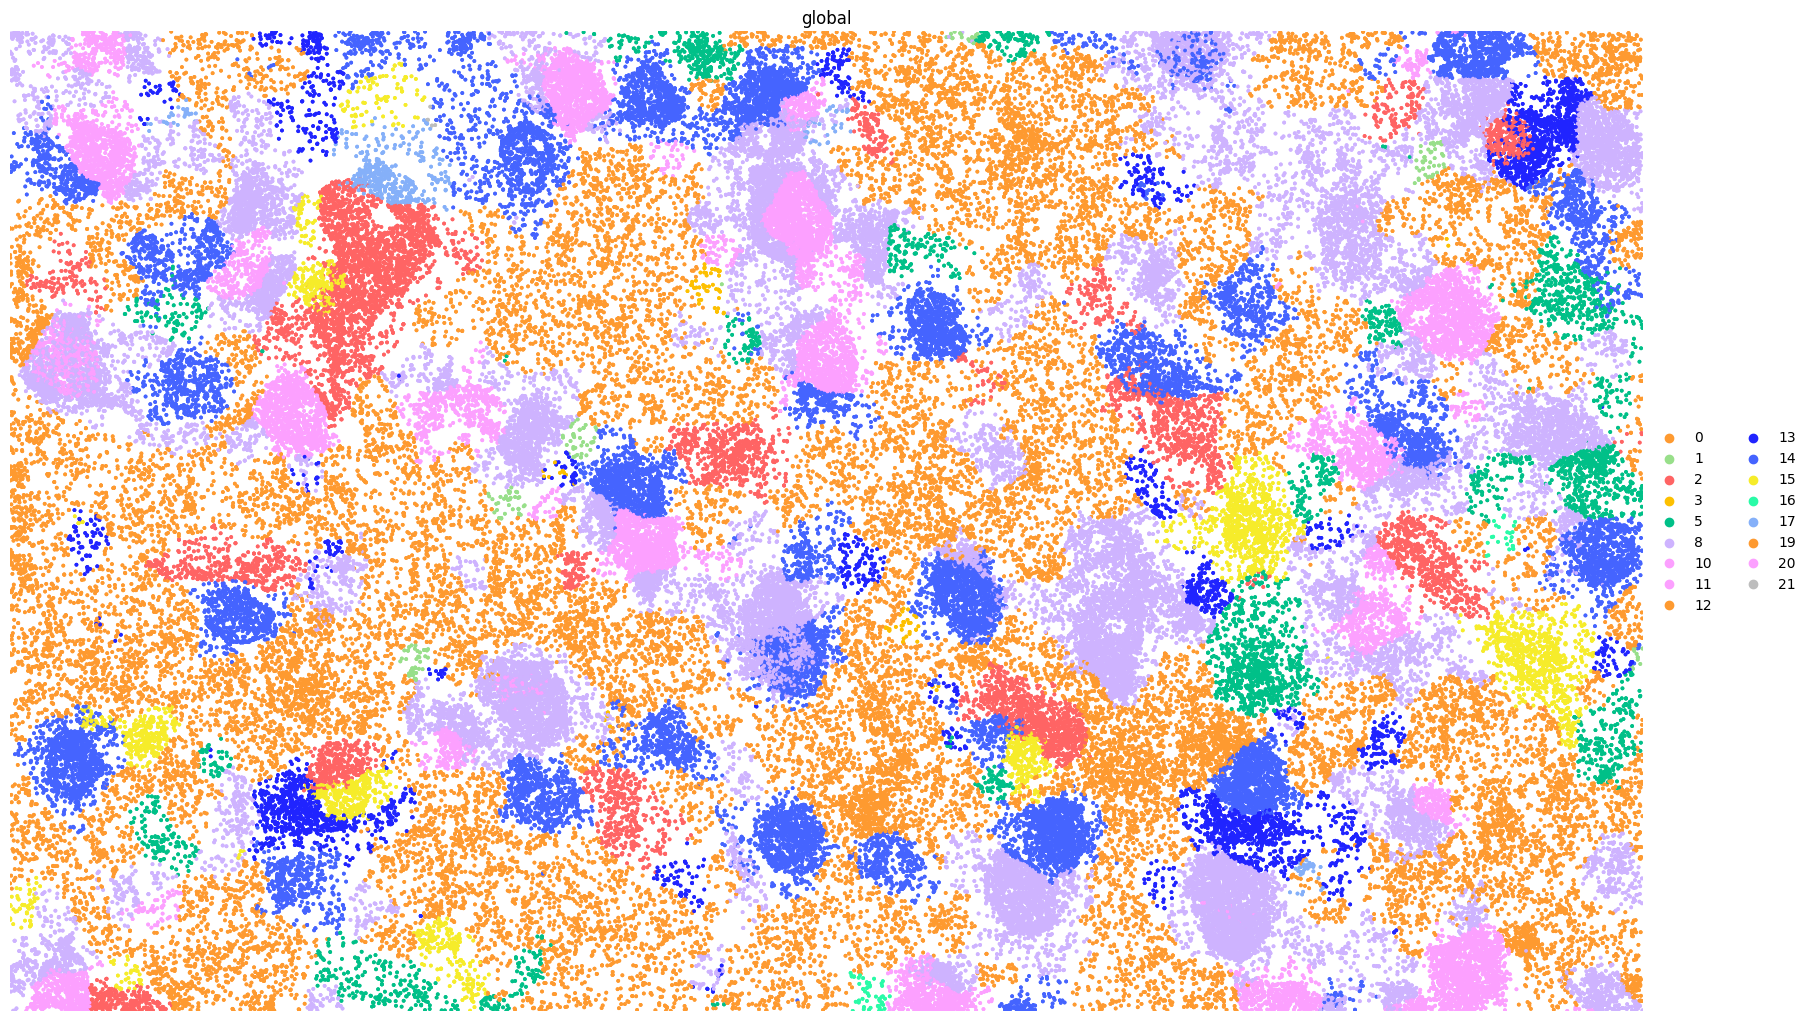

In [83]:
plot = sdata_sub.pl.render_points(
    fict_element,
    color=f"{factor_abbr}_factors",
    palette=list(factor_to_color.values()),
    groups=[str(k) for k in factor_to_color.keys()],
    size=3,
    method="matplotlib",
)
fig = plot.pl.show(figsize=(18, 18))
plt.axis("off")
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()

In [121]:
# arteriole
# pixel scale
vname = "arteriole1"
bb_xmin = 56500
bb_ymin = 15200
bb_w = 2000
bb_h = 1450
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [122]:
sdata_sub = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

In [123]:
factor_to_color2 = factor_to_color.copy()
if 8 in factor_to_color2:
    del factor_to_color2[8]

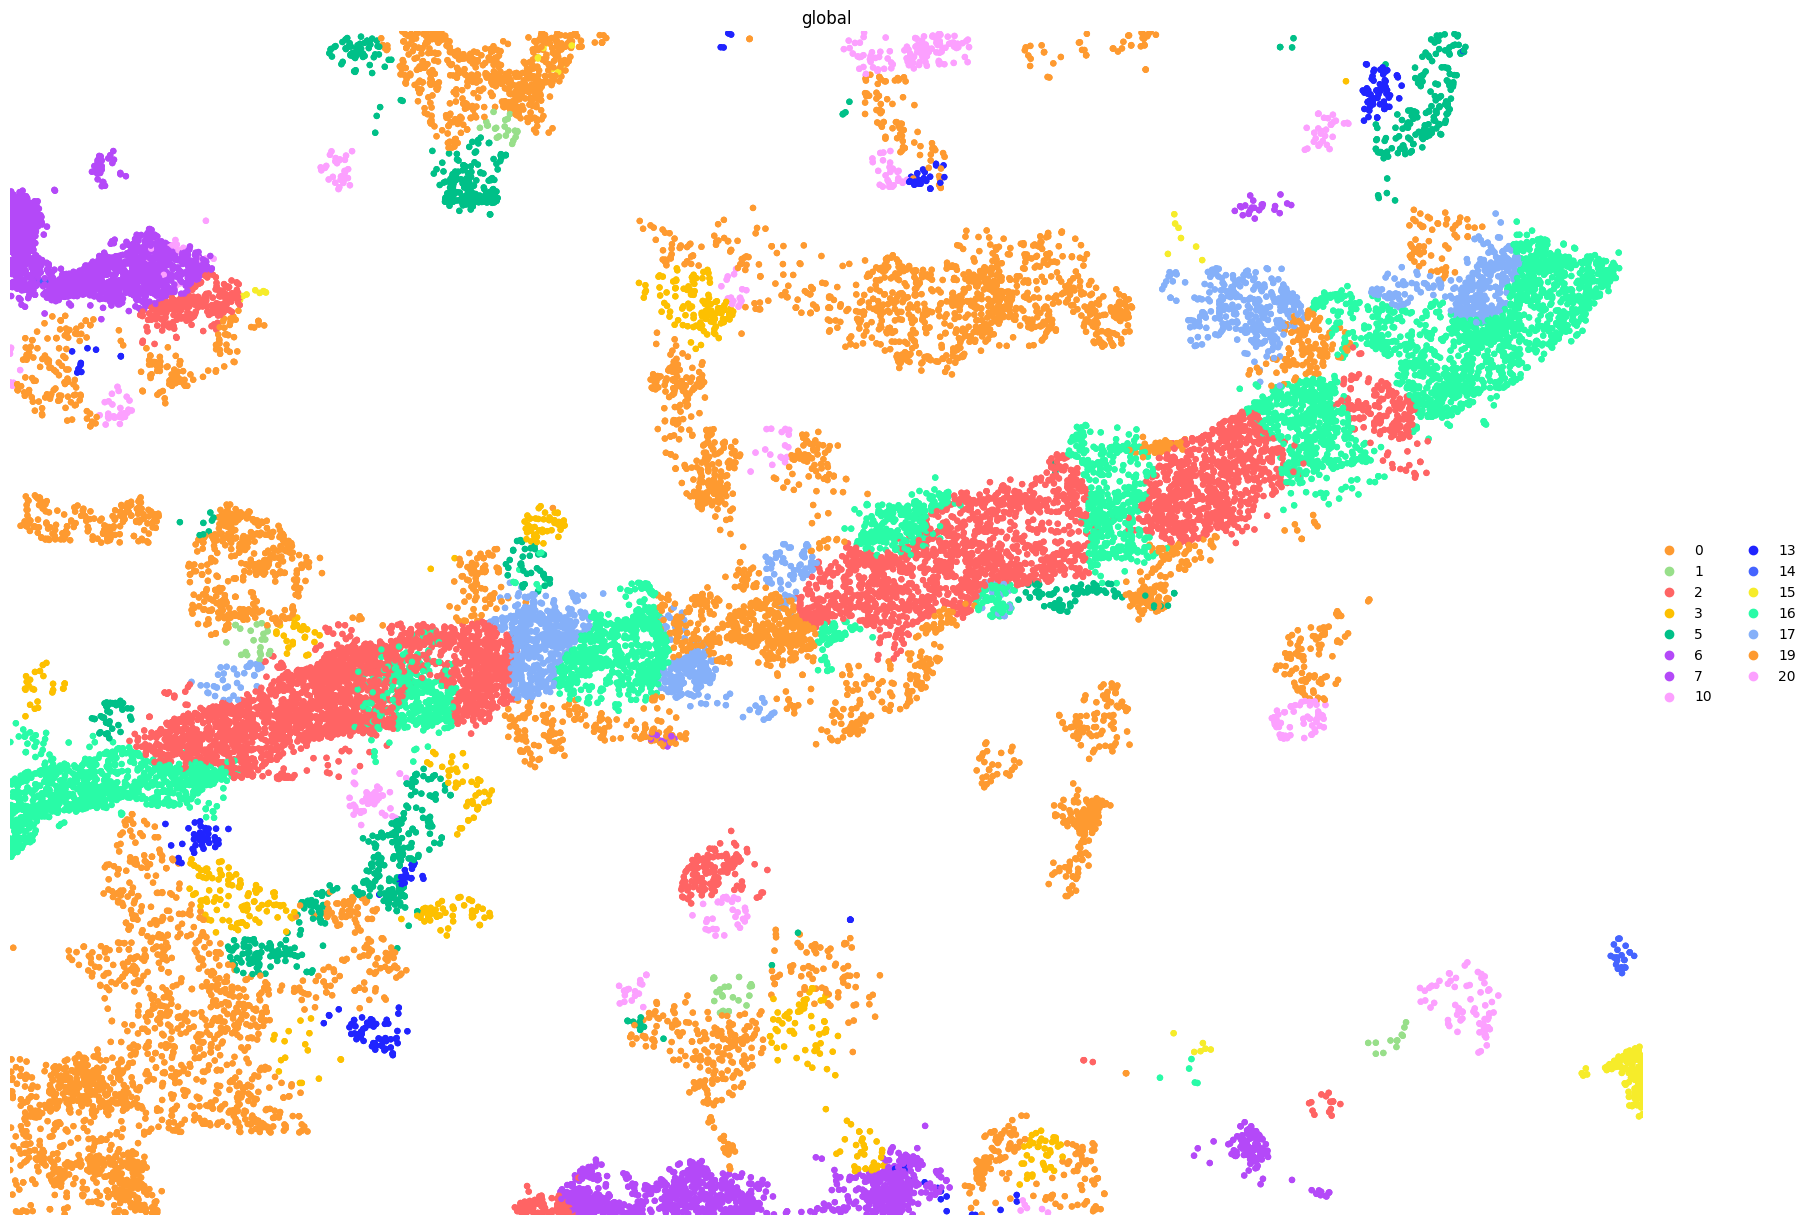

In [131]:
plot = sdata_sub.pl.render_points(
    fict_element,
    color=f"{factor_abbr}_factors",
    palette=list(factor_to_color2.values()),
    groups=[str(k) for k in factor_to_color2.keys()],
    size=13,
    method="matplotlib",
)
fig = plot.pl.show(figsize=(18, 18))
plt.axis("off")
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()

In [132]:
# oligos
# pixel scale
vname = "oligos1"
bb_xmin = 26000
bb_ymin = 20800
bb_w = 2000
bb_h = 1400
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [133]:
sdata_sub_oligo = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

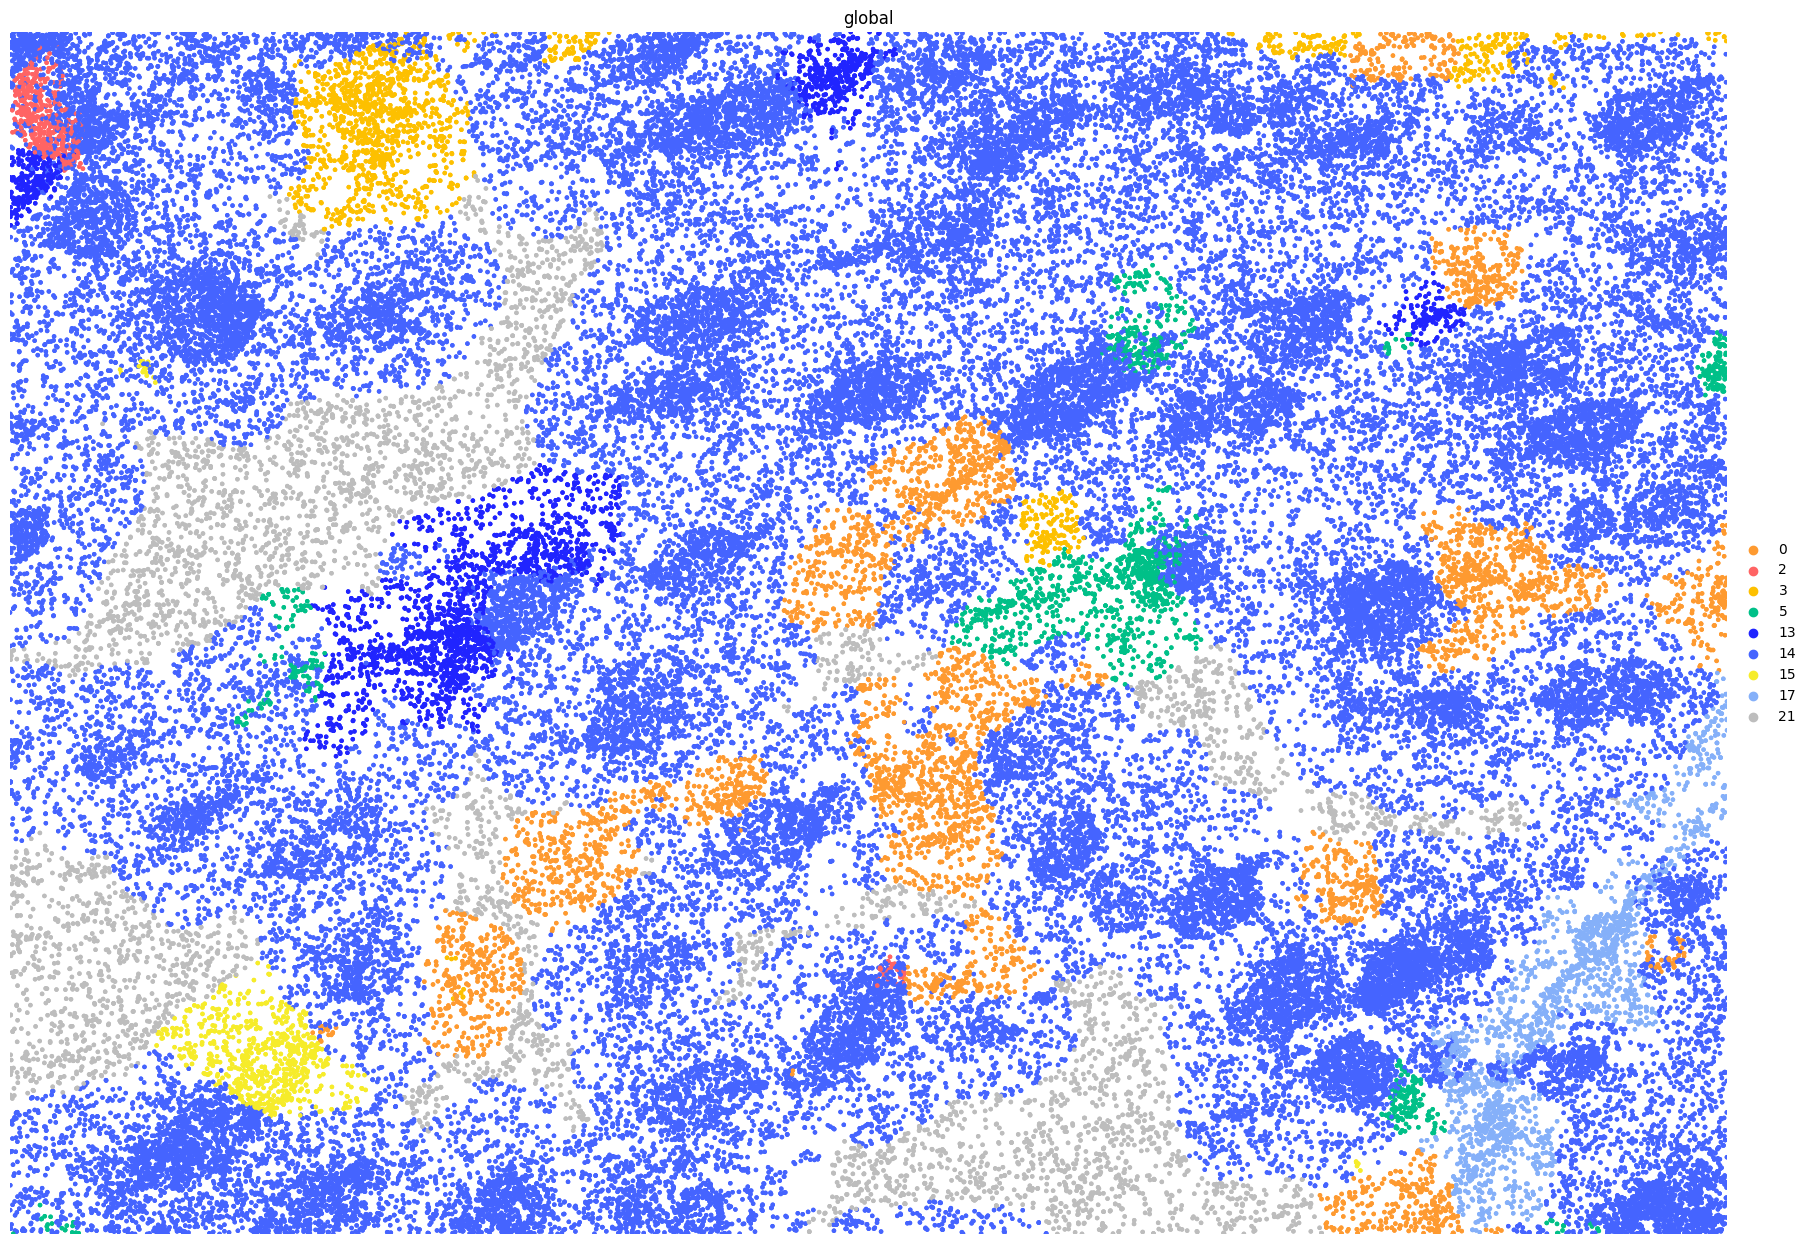

In [134]:
plot = sdata_sub_oligo.pl.render_points(
    fict_element,
    color=f"{factor_abbr}_factors",
    palette=list(factor_to_color2.values()),
    groups=[str(k) for k in factor_to_color2.keys()],
    size=5,
    method="matplotlib",
)
fig = plot.pl.show(figsize=(18, 18))
plt.axis("off")
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()

In [135]:
# neurons
# pixel scale
vname = "neurons1"
bb_xmin = 30100
bb_ymin = 4500
bb_w = 2100
bb_h = 1500
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

In [135]:
sdata_sub_neuron = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

In [ ]:
plot = sdata_sub_neuron.pl.render_points(
    fict_element,
    color=f"{factor_abbr}_factors",
    palette=list(factor_to_color2.values()),
    groups=[str(k) for k in factor_to_color2.keys()],
    size=5,
    method="matplotlib",
)
fig = plot.pl.show(figsize=(18, 18))
plt.axis("off")
plt.savefig(
    os.path.join(output_dir, f"{today}_Ficture_{vname}.png"),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.2,
    transparent=True,
)
plt.show()